# 🧠 Modelo para Avaliação de Estratégias em Classes Desbalanceadas  

Este notebook apresenta a construção de uma **rede neural convolucional (CNN)** para avaliar diferentes estratégias de tratamento de **classes desbalanceadas** no banco de dados **BRSET**, voltado à classificação de **retinopatia diabética**.  

⚠️ No dataset, apenas **6,58% das imagens** correspondem a casos positivos da doença, tornando o problema desafiador.  

## 🎯 Objetivo  
Investigar o impacto de diferentes técnicas de **undersampling** e **oversampling** no desempenho do modelo, considerando métricas relevantes para o cenário médico.  


## 🔬 Estratégias Avaliadas  

### 📌 Fase 1 – Amostragem Aleatória  
- Redução (**undersampling**) ou aumento (**oversampling**) simples e aleatórios.  
- Treinamento por até **30 épocas**, com **early stopping baseado na sensibilidade**, tolerância de **1 época**.  

### 📌 Fase 2 – Clusterização  
- Aplicação de **undersampling** e **oversampling** com preservação de padrões via **clusterização em 20 grupos**.  
- Treinamento também limitado a **30 épocas**, mas com **early stopping baseado no AUC-ROC**, tolerância de **3 épocas**.  


## 📊 Observação  
As métricas de avaliação incluem **Acurácia, Sensibilidade, Precisão, F1-Score, Especificidade e AUC-ROC**, além de ajustes de **threshold** via **F1-β (β = 1,5)**.  


# ⭐ Iniciando ambiente e capturando os dados

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,roc_auc_score, confusion_matrix, precision_recall_curve)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (ReduceLROnPlateau, EarlyStopping, ModelCheckpoint)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
file_path = ''
image_dir = ''

Mounted at /content/drive


In [ ]:
df = pd.read_csv(file_path)
df = df[['image_id', 'diabetic_retinopathy']]
class_counts = df['diabetic_retinopathy'].value_counts()

🖼️ Imagens selecionadas:
       diabetic_retinopathy  image_id
5093                      0  img05094
8153                      0  img08154
4401                      0  img04402
3452                      1  img03453
12471                     1  img12472
2754                      1  img02755


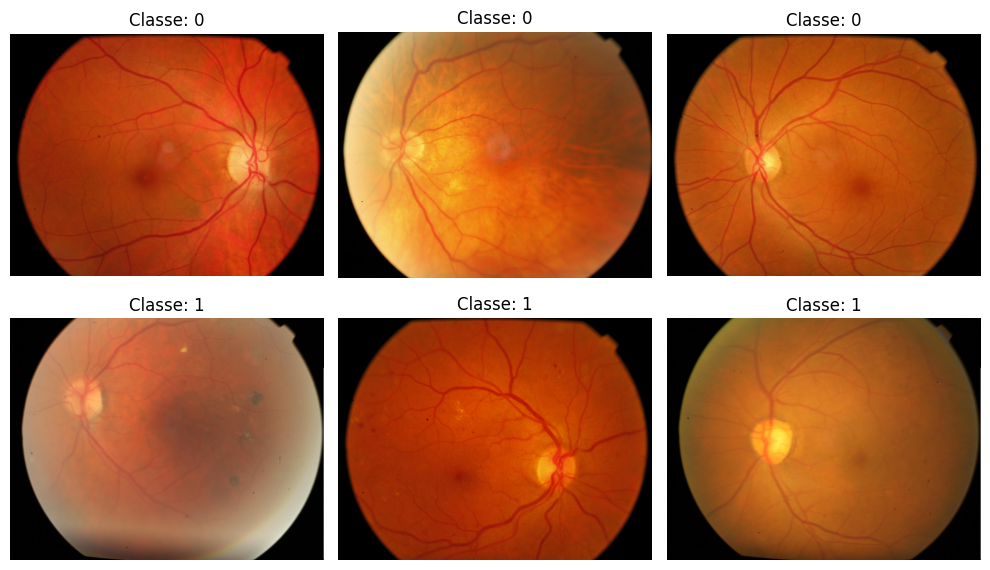

In [ ]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

# Lê o CSV
df = pd.read_csv(file_path)
df = df[['image_id', 'diabetic_retinopathy']]

# Seleciona 3 imagens aleatórias por classe
samples = df.groupby('diabetic_retinopathy', group_keys=False).sample(3, random_state=None)

print("🖼️ Imagens selecionadas:")
print(samples[['diabetic_retinopathy', 'image_id']])

# Exibe as imagens
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for ax, row in zip(axes.flatten(), samples.itertuples()):
    # tenta encontrar o arquivo com extensão
    for ext in ['.jpg', '.jpeg', '.png']:
        img_path = os.path.join(image_dir, row.image_id + ext)
        if os.path.exists(img_path):
            break
    else:
        print(f"⚠️ Arquivo não encontrado para {row.image_id}")
        ax.axis("off")
        continue

    img = Image.open(img_path)
    ax.imshow(img, aspect='equal')
    ax.set_title(f"Classe: {row.diabetic_retinopathy}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
train_val_df, test_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df['diabetic_retinopathy'],
    random_state=42
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.214,
    stratify=train_val_df['diabetic_retinopathy'],
    random_state=42
)

In [ ]:
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.10,
    shear_range=0.05,
    brightness_range=(0.8, 1.2),
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

val_aug = ImageDataGenerator(rescale=1./255)

Mounted at /content/drive


# 📠 Criando o Modelo

In [ ]:
model = Sequential([

    Conv2D(128, (3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(32, (2,2), activation='relu', padding='same'),
    Conv2D(16, (1,1), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(16, (1,1), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Flatten(),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')

])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 16)     │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 16)     │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,329 (934.88 KB)

 Trainable params: 238,817 (932.88 KB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
lr_reduction = ReduceLROnPlateau(
    monitor='val_auc_roc',
    mode='max',
    patience=3,
    factor=0.5,
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_auc_roc',
    mode='max',
    patience=3,
    restore_best_weights=True
)

In [ ]:
def avaliar_modelo(model, test_gen, test_df):
    y_pred = model.predict(test_gen)
    y_pred = (y_pred > 0.5).astype(int).flatten()

    y_true = test_df['diabetic_retinopathy'].values

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")

# Fase 1

# APLICANDO UNDERSAMPLING
Aplicando undersampling de modo que a classe maioritaria se iguale a classe minoritaria de 6%

In [ ]:
minor_df = train_df[train_df['diabetic_retinopathy'] == 1]
major_df = train_df[train_df['diabetic_retinopathy'] == 0]

major_undersampled = major_df.sample(len(minor_df), replace=False, random_state=42)
train_df_balanced = pd.concat([minor_df, major_undersampled]).sample(frac=1, random_state=42)

train_df_balanced['filepath'] = image_dir + '/' + train_df_balanced['image_id'] + '.jpg'

for split_df in [train_df_balanced, val_df, test_df]:
    split_df['filepath'] = image_dir + '/' + split_df['image_id'] + '.jpg'

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df_balanced,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

val_gen = val_aug.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

test_gen = val_aug.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.AUC(name='auc_roc'),
            tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/undersampling.h5',
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[lr_reduction, early_stop, checkpoint]
)

avaliar_modelo(model, test_gen, test_df)

Found 1178 validated image filenames.
Found 2437 validated image filenames.
Found 4880 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.4731 - auc_pr: 0.5189 - auc_roc: 0.4930 - loss: 0.8521 - precision: 0.4846 - recall: 0.4544 
Epoch 1: val_recall improved from -inf to 0.56875, saving model to /content/drive/MyDrive/undersampling.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1303s 70s/step - accuracy: 0.4751 - auc_pr: 0.5199 - auc_roc: 0.4950 - loss: 0.8505 - precision: 0.4860 - recall: 0.4570 - val_accuracy: 0.5815 - val_auc_pr: 0.1099 - val_auc_roc: 0.6180 - val_loss: 0.6892 - val_precision: 0.0873 - val_recall: 0.5688 - learning_rate: 0.0010
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6177 - auc_pr: 0.6303 - auc_roc: 0.6599 - loss: 0.6811 - precision: 0.6258 - recall: 0.5794
Epoch 2: val_recall did not improve from 0.56875
19/19 ━━━━━━━━━━━━━━━━━━━━ 170s 9s/step - accuracy: 0.6184 - auc_pr: 0.6316 - auc_roc: 0.6603 - loss: 0.6808 - precision: 0.6264 - recall: 0.5811 - val_accuracy: 0.9278 - val_auc_pr: 0.1086 - val_auc_roc: 0.6098 - val_loss: 0.5692 - val_precision: 0.1000 - val_recall: 0.0125 - learning_rate: 0.0010
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6539 - auc_pr: 0.6966 - auc_roc: 0.6825 - loss: 0.6653 - precision: 0.6636 - recall: 0.6033
Epoch 3: val_recall did not improve fro

# APLICANDO OVERSAMPLING
Aplicando oversampling de modo que a classe minoriatria se iguale a classe minoritaria de 94%

In [ ]:
minor_df = train_df[train_df['diabetic_retinopathy'] == 1]
major_df = train_df[train_df['diabetic_retinopathy'] == 0]

minor_oversampled = minor_df.sample(len(major_df), replace=True, random_state=42)
train_df_balanced = pd.concat([major_df, minor_oversampled]).sample(frac=1, random_state=42)

train_df_balanced['filepath'] = image_dir + '/' + train_df_balanced['image_id'] + '.jpg'

for split_df in [train_df_balanced, val_df, test_df]:
    split_df['filepath'] = image_dir + '/' + split_df['image_id'] + '.jpg'

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df_balanced,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

val_gen = val_aug.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

test_gen = val_aug.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

print("Treino:")
print(train_df['diabetic_retinopathy'].value_counts())

# Para validação
print("\nValidação:")
print(val_df['diabetic_retinopathy'].value_counts())

# Para teste
print("\nTeste:")
print(test_df['diabetic_retinopathy'].value_counts())

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.AUC(name='auc_roc'),
            tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/oversampling.h5',
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[lr_reduction, early_stop, checkpoint]
)

avaliar_modelo(model, test_gen, test_df)

Found 16720 validated image filenames.
Found 2437 validated image filenames.
Found 4880 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6417 - auc_pr: 0.6914 - auc_roc: 0.6812 - loss: 0.6507 - precision: 0.6643 - recall: 0.5844 
Epoch 1: val_recall improved from -inf to 0.20000, saving model to /content/drive/MyDrive/oversampling.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 4347s 17s/step - accuracy: 0.6417 - auc_pr: 0.6915 - auc_roc: 0.6813 - loss: 0.6506 - precision: 0.6644 - recall: 0.5844 - val_accuracy: 0.9229 - val_auc_pr: 0.2008 - val_auc_roc: 0.7273 - val_loss: 0.4265 - val_precision: 0.3478 - val_recall: 0.2000 - learning_rate: 0.0010
Epoch 2/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7236 - auc_pr: 0.7910 - auc_roc: 0.7819 - loss: 0.5645 - precision: 0.7594 - recall: 0.6563
Epoch 2: val_recall improved from 0.20000 to 0.42500, saving model to /content/drive/MyDrive/oversampling.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 979s 4s/step - accuracy: 0.7237 - auc_pr: 0.7910 - auc_roc: 0.7819 - loss: 0.5644 - precision: 0.7595 - recall: 0.6564 - val_accuracy: 0.9023 - val_auc_pr: 0.3314 - val_auc_roc: 0.8090 - val_loss: 0.3531 - val_precision: 0.3178 - val_recall: 0.4250 - learning_rate: 0.0010
Epoch 3/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7635 - auc_pr: 0.8449 - auc_roc: 0.8384 - loss: 0.5033 - precision: 0.8005 - recall: 0.7083
Epoch 3: val_recall improved from 0.42500 to 0.61875, saving model to /content/drive/MyDrive/oversampling.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 978s 4s/step - accuracy: 0.7635 - auc_pr: 0.8449 - auc_roc: 0.8384 - loss: 0.5033 - precision: 0.8005 - recall: 0.7083 - val_accuracy: 0.8687 - val_auc_pr: 0.4294 - val_auc_roc: 0.8359 - val_loss: 0.3842 - val_precision: 0.2765 - val_recall: 0.6187 - learning_rate: 0.0010
Epoch 4/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7865 - auc_pr: 0.8684 - auc_roc: 0.8624 - loss: 0.4660 - precision: 0.8115 - recall: 0.7474
Epoch 4: val_recall improved from 0.61875 to 0.63125, saving model to /content/drive/MyDrive/oversampling.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 990s 4s/step - accuracy: 0.7865 - auc_pr: 0.8684 - auc_roc: 0.8624 - loss: 0.4660 - precision: 0.8115 - recall: 0.7474 - val_accuracy: 0.8412 - val_auc_pr: 0.4247 - val_auc_roc: 0.8521 - val_loss: 0.4055 - val_precision: 0.2354 - val_recall: 0.6313 - learning_rate: 0.0010
Epoch 5/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7874 - auc_pr: 0.8710 - auc_roc: 0.8669 - loss: 0.4600 - precision: 0.8158 - recall: 0.7434
Epoch 5: val_recall did not improve from 0.63125
262/262 ━━━━━━━━━━━━━━━━━━━━ 1009s 4s/step - accuracy: 0.7875 - auc_pr: 0.8711 - auc_roc: 0.8669 - loss: 0.4599 - precision: 0.8158 - recall: 0.7435 - val_accuracy: 0.8966 - val_auc_pr: 0.4974 - val_auc_roc: 0.8739 - val_loss: 0.3099 - val_precision: 0.3369 - val_recall: 0.5938 - learning_rate: 0.0010
Epoch 6/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8079 - auc_pr: 0.8894 - auc_roc: 0.8897 - loss: 0.4216 - precision: 0.8222 - recall: 0.7772
Epoch 6: val_recall did not impr

262/262 ━━━━━━━━━━━━━━━━━━━━ 1020s 4s/step - accuracy: 0.8120 - auc_pr: 0.8909 - auc_roc: 0.8927 - loss: 0.4187 - precision: 0.8273 - recall: 0.7834 - val_accuracy: 0.8929 - val_auc_pr: 0.5235 - val_auc_roc: 0.8663 - val_loss: 0.2791 - val_precision: 0.3397 - val_recall: 0.6687 - learning_rate: 0.0010
Epoch 8/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8319 - auc_pr: 0.9089 - auc_roc: 0.9076 - loss: 0.3875 - precision: 0.8400 - recall: 0.8223
Epoch 8: val_recall improved from 0.66875 to 0.88125, saving model to /content/drive/MyDrive/oversampling.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 1024s 4s/step - accuracy: 0.8319 - auc_pr: 0.9090 - auc_roc: 0.9076 - loss: 0.3875 - precision: 0.8400 - recall: 0.8223 - val_accuracy: 0.7173 - val_auc_pr: 0.4788 - val_auc_roc: 0.8812 - val_loss: 0.6601 - val_precision: 0.1739 - val_recall: 0.8813 - learning_rate: 0.0010
Epoch 9/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8347 - auc_pr: 0.9151 - auc_roc: 0.9169 - loss: 0.3685 - precision: 0.8380 - recall: 0.8265
Epoch 9: val_recall did not improve from 0.88125
262/262 ━━━━━━━━━━━━━━━━━━━━ 1022s 4s/step - accuracy: 0.8347 - auc_pr: 0.9152 - auc_roc: 0.9169 - loss: 0.3685 - precision: 0.8380 - recall: 0.8265 - val_accuracy: 0.8211 - val_auc_pr: 0.5242 - val_auc_roc: 0.8906 - val_loss: 0.4416 - val_precision: 0.2463 - val_recall: 0.8375 - learning_rate: 0.0010
Epoch 10/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8466 - auc_pr: 0.9222 - auc_roc: 0.9204 - loss: 0.3617 - precision: 0.8557 - recall: 0.8350
Epoch 10: val_recall did not i

In [ ]:
from tensorflow.keras.models import load_model

minor_df = train_df[train_df['diabetic_retinopathy'] == 1]
major_df = train_df[train_df['diabetic_retinopathy'] == 0]

image_dir = '/content/drive/MyDrive/IC - Fundo de Olhoo/unzipped/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.1/fundus_photos'

minor_oversampled = minor_df.sample(len(major_df), replace=True, random_state=42)
train_df_balanced = pd.concat([major_df, minor_oversampled]).sample(frac=1, random_state=42)

train_df_balanced['filepath'] = image_dir + '/' + train_df_balanced['image_id'] + '.jpg'

for split_df in [train_df_balanced, val_df, test_df]:
    split_df['filepath'] = image_dir + '/' + split_df['image_id'] + '.jpg'

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df_balanced,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

val_gen = val_aug.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

test_gen = val_aug.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

model = load_model('/content/drive/MyDrive/oversampling.h5')

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/oversampling.h5',
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc_roc'),
        tf.keras.metrics.AUC(curve='PR', name='auc_pr')
    ]
)

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    initial_epoch=18,
    callbacks=[lr_reduction, early_stop, checkpoint]
)

avaliar_modelo(model, test_gen, test_df)

Found 16720 validated image filenames.
Found 2437 validated image filenames.
Found 4880 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 19/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.8356 - auc_pr: 0.9145 - auc_roc: 0.9158 - loss: 0.3717 - precision: 0.8453 - recall: 0.8233 
Epoch 19: val_recall improved from -inf to 0.76875, saving model to /content/drive/MyDrive/oversampling.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 10116s 39s/step - accuracy: 0.8356 - auc_pr: 0.9145 - auc_roc: 0.9158 - loss: 0.3717 - precision: 0.8453 - recall: 0.8233 - val_accuracy: 0.8572 - val_auc_pr: 0.5454 - val_auc_roc: 0.8908 - val_loss: 0.3679 - val_precision: 0.2834 - val_recall: 0.7688 - learning_rate: 0.0010
Epoch 20/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8454 - auc_pr: 0.9229 - auc_roc: 0.9229 - loss: 0.3561 - precision: 0.8528 - recall: 0.8353
Epoch 20: val_recall did not improve from 0.76875
262/262 ━━━━━━━━━━━━━━━━━━━━ 999s 4s/step - accuracy: 0.8454 - auc_pr: 0.9229 - auc_roc: 0.9229 - loss: 0.3560 - precision: 0.8528 - recall: 0.8353 - val_accuracy: 0.9257 - val_auc_pr: 0.5342 - val_auc_roc: 0.9041 - val_loss: 0.2109 - val_precision: 0.4533 - val_recall: 0.6375 - learning_rate: 0.0010
Epoch 21/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8621 - auc_pr: 0.9349 - auc_roc: 0.9332 - loss: 0.3310 - precision: 0.8754 - recall: 0.8461
Epoch 21: val_recall did no

262/262 ━━━━━━━━━━━━━━━━━━━━ 1027s 4s/step - accuracy: 0.8603 - auc_pr: 0.9324 - auc_roc: 0.9341 - loss: 0.3294 - precision: 0.8655 - recall: 0.8525 - val_accuracy: 0.7805 - val_auc_pr: 0.5264 - val_auc_roc: 0.8972 - val_loss: 0.5215 - val_precision: 0.2066 - val_recall: 0.8250 - learning_rate: 0.0010
Epoch 24/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8832 - auc_pr: 0.9470 - auc_roc: 0.9492 - loss: 0.2901 - precision: 0.8852 - recall: 0.8817
Epoch 24: val_recall did not improve from 0.82500
262/262 ━━━━━━━━━━━━━━━━━━━━ 1029s 4s/step - accuracy: 0.8832 - auc_pr: 0.9470 - auc_roc: 0.9492 - loss: 0.2901 - precision: 0.8852 - recall: 0.8817 - val_accuracy: 0.9064 - val_auc_pr: 0.5641 - val_auc_roc: 0.8967 - val_loss: 0.2456 - val_precision: 0.3851 - val_recall: 0.7125 - learning_rate: 5.0000e-04
Epoch 25/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8835 - auc_pr: 0.9488 - auc_roc: 0.9523 - loss: 0.2819 - precision: 0.8793 - recall: 0.8873
Epoch 25: val_recall did

# Fase 2

# CLUSTER + UNDERSAMPLING
Utilizando o cluster e o undersampling para teste

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from tensorflow.keras.applications import EfficientNetB0

minor_df = train_df[train_df['diabetic_retinopathy'] == 1]
major_df = train_df[train_df['diabetic_retinopathy'] == 0]

datagen = ImageDataGenerator(rescale=1./255)
major_df['filepath'] = image_dir + '/' + major_df['image_id'] + '.jpg'

neg_gen = datagen.flow_from_dataframe(
    dataframe=major_df,
    x_col='filepath',
    y_col=None,
    target_size=(224,224),
    class_mode=None,
    shuffle=False,
    batch_size=64
)

base_model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")
embeddings = base_model.predict(neg_gen, verbose=1)

kmeans = MiniBatchKMeans(n_clusters=20, random_state=42, batch_size=512)
clusters = kmeans.fit_predict(embeddings)

major_df['cluster'] = clusters

minor_count = len(minor_df)
num_clusters = major_df['cluster'].nunique()
samples_per_cluster = minor_count // num_clusters

undersampled_list = []

for current_cluster in range(num_clusters):

    cluster_df = major_df[major_df['cluster'] == current_cluster]
    if len(cluster_df) <= samples_per_cluster:
        undersampled_list.append(cluster_df)
    else:
        undersampled_list.append(cluster_df.sample(samples_per_cluster, random_state=42))

major_undersampled = pd.concat(undersampled_list).reset_index(drop=True)

train_df_balanced = pd.concat([minor_df, major_undersampled]).sample(frac=1, random_state=42)
train_df_balanced['filepath'] = image_dir + '/' + train_df_balanced['image_id'] + '.jpg'

for split_df in [train_df_balanced, val_df, test_df]:
    split_df['filepath'] = image_dir + '/' + split_df['image_id'] + '.jpg'

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df_balanced,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

val_gen = val_aug.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

test_gen = val_aug.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.AUC(name='auc_roc'),
            tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/undersampling_cluster.h5',
    mode='max',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[lr_reduction, early_stop, checkpoint]
)

avaliar_modelo(model, test_gen, test_df)

/tmp/ipython-input-640005820.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_df['filepath'] = image_dir + '/' + major_df['image_id'] + '.jpg'


Found 8360 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step
Found 1169 validated image filenames.


/tmp/ipython-input-640005820.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  major_df['cluster'] = clusters


Found 2437 validated image filenames.
Found 4880 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5583 - auc_pr: 0.5521 - auc_roc: 0.5776 - loss: 0.7895 - precision: 0.5480 - recall: 0.5839
Epoch 1: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 180s 9s/step - accuracy: 0.5593 - auc_pr: 0.5532 - auc_roc: 0.5788 - loss: 0.7889 - precision: 0.5493 - recall: 0.5864 - val_accuracy: 0.9294 - val_auc_pr: 0.0950 - val_auc_roc: 0.6087 - val_loss: 0.5924 - val_precision: 0.1250 - val_recall: 0.0125 - learning_rate: 0.0010
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6349 - auc_pr: 0.6319 - auc_roc: 0.6630 - loss: 0.7008 - precision: 0.6267 - recall: 0.7002
Epoch 2: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 170s 9s/step - accuracy: 0.6339 - auc_pr: 0.6304 - auc_roc: 0.6622 - loss: 0.7012 - precision: 0.6257 - recall: 0.6992 - val_accuracy: 0.0661 - val_auc_pr: 0.1084 - val_auc_roc: 0.5987 - val_loss: 0.8222 - val_precision: 0.0657 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5712 - auc_pr: 0.5933 - auc_roc: 0.6028 - loss: 0.7446 - precision: 0.5734 - recall: 0.6007
Epoch 3: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 170s 9s/step - accuracy: 0.5720 - auc_pr: 0.5940 - auc_roc: 0.6040 - loss: 0.7435 - precision: 0.5741 - recall: 0.6010 - val_accuracy: 0.0657 - val_auc_pr: 0.1228 - val_auc_roc: 0.6356 - val_loss: 0.8550 - val_precision: 0.0657 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5911 - auc_pr: 0.6487 - auc_roc: 0.6407 - loss: 0.7177 - precision: 0.5926 - recall: 0.6292
Epoch 4: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 0.5915 - auc_pr: 0.6481 - auc_roc: 0.6410 - loss: 0.7171 - precision: 0.5928 - recall: 0.6291 - val_accuracy: 0.4826 - val_auc_pr: 0.1360 - val_auc_roc: 0.6205 - val_loss: 0.6943 - val_precision: 0.0807 - val_recall: 0.6625 - learning_rate: 0.0010
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6188 - auc_pr: 0.6809 - auc_roc: 0.6744 - loss: 0.6874 - precision: 0.6175 - recall: 0.6627
Epoch 5: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 170s 9s/step - accuracy: 0.6190 - auc_pr: 0.6802 - auc_roc: 0.6744 - loss: 0.6872 - precision: 0.6176 - recall: 0.6625 - val_accuracy: 0.3861 - val_auc_pr: 0.1158 - val_auc_roc: 0.6450 - val_loss: 0.7087 - val_precision: 0.0809 - val_recall: 0.8062 - learning_rate: 0.0010
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6687 - auc_pr: 0.6829 - auc_roc: 0.7090 - loss: 0.6410 - precision: 0.6506 - recall: 0.6875
Epoch 6: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 171s 9s/step - accuracy: 0.6674 - auc_pr: 0.6825 - auc_roc: 0.7075 - loss: 0.6425 - precision: 0.6502 - recall: 0.6858 - val_accuracy: 0.4982 - val_auc_pr: 0.0687 - val_auc_roc: 0.5355 - val_loss: 0.6916 - val_precision: 0.0751 - val_recall: 0.5875 - learning_rate: 0.0010
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6082 - auc_pr: 0.6759 - auc_roc: 0.6677 - loss: 0.6620 - precision: 0.6407 - recall: 0.6056
Epoch 7: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 0.6091 - auc_pr: 0.6753 - auc_roc: 0.6679 - loss: 0.6623 - precision: 0.6401 - recall: 0.6071 - val_accuracy: 0.2614 - val_auc_pr: 0.1210 - val_auc_roc: 0.6536 - val_loss: 0.7488 - val_precision: 0.0747 - val_recall: 0.9000 - learning_rate: 0.0010
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6608 - auc_pr: 0.7269 - auc_roc: 0.7249 - loss: 0.6369 - precision: 0.6664 - recall: 0.6781
Epoch 8: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 169s 9s/step - accuracy: 0.6603 - auc_pr: 0.7258 - auc_roc: 0.7242 - loss: 0.6372 - precision: 0.6655 - recall: 0.6778 - val_accuracy: 0.4666 - val_auc_pr: 0.1129 - val_auc_roc: 0.6144 - val_loss: 0.6957 - val_precision: 0.0796 - val_recall: 0.6750 - learning_rate: 0.0010
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6501 - auc_pr: 0.6918 - auc_roc: 0.7058 - loss: 0.6441 - precision: 0.6431 - recall: 0.6941
Epoch 9: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.6493 - auc_pr: 0.6906 - auc_roc: 0.7048 - loss: 0.6454 - precision: 0.6422 - recall: 0.6935 - val_accuracy: 0.5269 - val_auc_pr: 0.1435 - val_auc_roc: 0.6560 - val_loss: 0.6974 - val_precision: 0.0914 - val_recall: 0.6938 - learning_rate: 0.0010
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6346 - auc_pr: 0.7022 - auc_roc: 0.6860 - loss: 0.6507 - precision: 0.6588 - recall: 0.6049
Epoch 10: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 0.6345 - auc_pr: 0.7011 - auc_roc: 0.6855 - loss: 0.6512 - precision: 0.6578 - recall: 0.6057 - val_accuracy: 0.6504 - val_auc_pr: 0.1695 - val_auc_roc: 0.6680 - val_loss: 0.6607 - val_precision: 0.1077 - val_recall: 0.5938 - learning_rate: 0.0010
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6376 - auc_pr: 0.6595 - auc_roc: 0.6872 - loss: 0.6685 - precision: 0.6199 - recall: 0.6918
Epoch 11: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.6378 - auc_pr: 0.6597 - auc_roc: 0.6872 - loss: 0.6682 - precision: 0.6207 - recall: 0.6912 - val_accuracy: 0.7636 - val_auc_pr: 0.1466 - val_auc_roc: 0.6496 - val_loss: 0.6437 - val_precision: 0.1245 - val_recall: 0.4313 - learning_rate: 0.0010
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6266 - auc_pr: 0.6774 - auc_roc: 0.6794 - loss: 0.6668 - precision: 0.6301 - recall: 0.6090
Epoch 12: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.6275 - auc_pr: 0.6780 - auc_roc: 0.6800 - loss: 0.6662 - precision: 0.6311 - recall: 0.6107 - val_accuracy: 0.5211 - val_auc_pr: 0.1428 - val_auc_roc: 0.6630 - val_loss: 0.6948 - val_precision: 0.0923 - val_recall: 0.7125 - learning_rate: 0.0010
Epoch 13/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6467 - auc_pr: 0.6987 - auc_roc: 0.7078 - loss: 0.6323 - precision: 0.6337 - recall: 0.6727
Epoch 13: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.6467 - auc_pr: 0.6990 - auc_roc: 0.7079 - loss: 0.6323 - precision: 0.6342 - recall: 0.6726 - val_accuracy: 0.3632 - val_auc_pr: 0.1652 - val_auc_roc: 0.6945 - val_loss: 0.7318 - val_precision: 0.0812 - val_recall: 0.8438 - learning_rate: 0.0010
Epoch 14/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6527 - auc_pr: 0.7033 - auc_roc: 0.6977 - loss: 0.6338 - precision: 0.6626 - recall: 0.6760
Epoch 14: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.6530 - auc_pr: 0.7030 - auc_roc: 0.6979 - loss: 0.6340 - precision: 0.6628 - recall: 0.6749 - val_accuracy: 0.8646 - val_auc_pr: 0.1558 - val_auc_roc: 0.6960 - val_loss: 0.6175 - val_precision: 0.1942 - val_recall: 0.3375 - learning_rate: 0.0010
Epoch 15/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7016 - auc_pr: 0.6947 - auc_roc: 0.7343 - loss: 0.6171 - precision: 0.6856 - recall: 0.6992
Epoch 15: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.7004 - auc_pr: 0.6951 - auc_roc: 0.7333 - loss: 0.6177 - precision: 0.6856 - recall: 0.6976 - val_accuracy: 0.8277 - val_auc_pr: 0.1781 - val_auc_roc: 0.6737 - val_loss: 0.6122 - val_precision: 0.1667 - val_recall: 0.4062 - learning_rate: 0.0010
Epoch 16/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6503 - auc_pr: 0.6981 - auc_roc: 0.6893 - loss: 0.6519 - precision: 0.6703 - recall: 0.6414
Epoch 16: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 170s 9s/step - accuracy: 0.6507 - auc_pr: 0.6985 - auc_roc: 0.6901 - loss: 0.6516 - precision: 0.6697 - recall: 0.6427 - val_accuracy: 0.5343 - val_auc_pr: 0.1971 - val_auc_roc: 0.6612 - val_loss: 0.6971 - val_precision: 0.0914 - val_recall: 0.6812 - learning_rate: 0.0010
Epoch 17/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6738 - auc_pr: 0.7380 - auc_roc: 0.7202 - loss: 0.6273 - precision: 0.6867 - recall: 0.6864
Epoch 17: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.6729 - auc_pr: 0.7372 - auc_roc: 0.7197 - loss: 0.6273 - precision: 0.6853 - recall: 0.6848 - val_accuracy: 0.6951 - val_auc_pr: 0.1701 - val_auc_roc: 0.6577 - val_loss: 0.6147 - val_precision: 0.1159 - val_recall: 0.5500 - learning_rate: 0.0010
Epoch 18/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6637 - auc_pr: 0.7108 - auc_roc: 0.7029 - loss: 0.6381 - precision: 0.6710 - recall: 0.6908
Epoch 18: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.6625 - auc_pr: 0.7097 - auc_roc: 0.7024 - loss: 0.6386 - precision: 0.6690 - recall: 0.6905 - val_accuracy: 0.8777 - val_auc_pr: 0.1544 - val_auc_roc: 0.6696 - val_loss: 0.5914 - val_precision: 0.2240 - val_recall: 0.3500 - learning_rate: 5.0000e-04
Epoch 19/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6537 - auc_pr: 0.7124 - auc_roc: 0.7197 - loss: 0.6227 - precision: 0.6451 - recall: 0.6925
Epoch 19: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.6538 - auc_pr: 0.7125 - auc_roc: 0.7197 - loss: 0.6228 - precision: 0.6454 - recall: 0.6921 - val_accuracy: 0.8067 - val_auc_pr: 0.1608 - val_auc_roc: 0.6675 - val_loss: 0.5980 - val_precision: 0.1612 - val_recall: 0.4625 - learning_rate: 5.0000e-04
Epoch 20/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6494 - auc_pr: 0.7087 - auc_roc: 0.7182 - loss: 0.6248 - precision: 0.6492 - recall: 0.6623
Epoch 20: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 169s 9s/step - accuracy: 0.6501 - auc_pr: 0.7089 - auc_roc: 0.7186 - loss: 0.6246 - precision: 0.6501 - recall: 0.6623 - val_accuracy: 0.8572 - val_auc_pr: 0.1611 - val_auc_roc: 0.6734 - val_loss: 0.5869 - val_precision: 0.1948 - val_recall: 0.3750 - learning_rate: 5.0000e-04
Epoch 21/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6425 - auc_pr: 0.7234 - auc_roc: 0.7068 - loss: 0.6269 - precision: 0.6574 - recall: 0.6449
Epoch 21: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 0.6435 - auc_pr: 0.7241 - auc_roc: 0.7079 - loss: 0.6260 - precision: 0.6578 - recall: 0.6461 - val_accuracy: 0.7735 - val_auc_pr: 0.1809 - val_auc_roc: 0.6832 - val_loss: 0.6051 - val_precision: 0.1449 - val_recall: 0.5000 - learning_rate: 2.5000e-04
Epoch 22/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6595 - auc_pr: 0.7229 - auc_roc: 0.7176 - loss: 0.6095 - precision: 0.6499 - recall: 0.6835
Epoch 22: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.6603 - auc_pr: 0.7234 - auc_roc: 0.7180 - loss: 0.6096 - precision: 0.6510 - recall: 0.6837 - val_accuracy: 0.7575 - val_auc_pr: 0.1917 - val_auc_roc: 0.6876 - val_loss: 0.6006 - val_precision: 0.1426 - val_recall: 0.5375 - learning_rate: 2.5000e-04
Epoch 23/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6810 - auc_pr: 0.7383 - auc_roc: 0.7394 - loss: 0.6107 - precision: 0.6747 - recall: 0.6806
Epoch 23: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.6809 - auc_pr: 0.7390 - auc_roc: 0.7393 - loss: 0.6107 - precision: 0.6751 - recall: 0.6803 - val_accuracy: 0.7665 - val_auc_pr: 0.1918 - val_auc_roc: 0.6968 - val_loss: 0.6083 - val_precision: 0.1480 - val_recall: 0.5375 - learning_rate: 2.5000e-04
Epoch 24/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6585 - auc_pr: 0.7399 - auc_roc: 0.7128 - loss: 0.6312 - precision: 0.6782 - recall: 0.6652
Epoch 24: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.6588 - auc_pr: 0.7386 - auc_roc: 0.7127 - loss: 0.6310 - precision: 0.6776 - recall: 0.6656 - val_accuracy: 0.8112 - val_auc_pr: 0.1923 - val_auc_roc: 0.7041 - val_loss: 0.5905 - val_precision: 0.1725 - val_recall: 0.4938 - learning_rate: 2.5000e-04
Epoch 25/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7041 - auc_pr: 0.7598 - auc_roc: 0.7409 - loss: 0.6025 - precision: 0.7302 - recall: 0.6713
Epoch 25: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.7036 - auc_pr: 0.7593 - auc_roc: 0.7410 - loss: 0.6025 - precision: 0.7287 - recall: 0.6717 - val_accuracy: 0.8104 - val_auc_pr: 0.1966 - val_auc_roc: 0.6972 - val_loss: 0.5759 - val_precision: 0.1629 - val_recall: 0.4563 - learning_rate: 2.5000e-04
Epoch 26/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6605 - auc_pr: 0.7467 - auc_roc: 0.7274 - loss: 0.6180 - precision: 0.6882 - recall: 0.6517
Epoch 26: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.6608 - auc_pr: 0.7467 - auc_roc: 0.7279 - loss: 0.6175 - precision: 0.6872 - recall: 0.6526 - val_accuracy: 0.8207 - val_auc_pr: 0.2115 - val_auc_roc: 0.6968 - val_loss: 0.5639 - val_precision: 0.1772 - val_recall: 0.4750 - learning_rate: 2.5000e-04
Epoch 27/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6925 - auc_pr: 0.7750 - auc_roc: 0.7598 - loss: 0.5813 - precision: 0.7013 - recall: 0.6761
Epoch 27: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.6923 - auc_pr: 0.7748 - auc_roc: 0.7597 - loss: 0.5814 - precision: 0.7010 - recall: 0.6761 - val_accuracy: 0.8966 - val_auc_pr: 0.1808 - val_auc_roc: 0.6849 - val_loss: 0.5087 - val_precision: 0.2229 - val_recall: 0.2313 - learning_rate: 2.5000e-04
Epoch 28/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6528 - auc_pr: 0.7366 - auc_roc: 0.7244 - loss: 0.6129 - precision: 0.6733 - recall: 0.6392
Epoch 28: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.6537 - auc_pr: 0.7369 - auc_roc: 0.7251 - loss: 0.6123 - precision: 0.6735 - recall: 0.6402 - val_accuracy: 0.8309 - val_auc_pr: 0.1911 - val_auc_roc: 0.6870 - val_loss: 0.5376 - val_precision: 0.1719 - val_recall: 0.4125 - learning_rate: 1.2500e-04
Epoch 29/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6842 - auc_pr: 0.7540 - auc_roc: 0.7421 - loss: 0.5990 - precision: 0.6887 - recall: 0.6475
Epoch 29: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 169s 9s/step - accuracy: 0.6844 - auc_pr: 0.7539 - auc_roc: 0.7420 - loss: 0.5992 - precision: 0.6896 - recall: 0.6479 - val_accuracy: 0.8285 - val_auc_pr: 0.2039 - val_auc_roc: 0.6939 - val_loss: 0.5353 - val_precision: 0.1775 - val_recall: 0.4437 - learning_rate: 1.2500e-04
Epoch 30/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6843 - auc_pr: 0.7385 - auc_roc: 0.7410 - loss: 0.5982 - precision: 0.6863 - recall: 0.6452
Epoch 30: saving model to /content/drive/MyDrive/undersampling_cluster.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 0.6844 - auc_pr: 0.7392 - auc_roc: 0.7410 - loss: 0.5983 - precision: 0.6872 - recall: 0.6456 - val_accuracy: 0.8437 - val_auc_pr: 0.2028 - val_auc_roc: 0.6914 - val_loss: 0.5341 - val_precision: 0.1905 - val_recall: 0.4250 - learning_rate: 1.2500e-04
32/77 ━━━━━━━━━━━━━━━━━━━━ 13:14 18s/step

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import load_model

image_dir = '/content/drive/MyDrive/IC - Fundo de Olhoo/unzipped/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.1/fundus_photos'

test_df['filepath'] = image_dir + '/' + test_df['image_id'] + '.jpg'

test_gen = val_aug.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

model = load_model('/content/drive/MyDrive/undersampling_cluster.h5')

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.AUC(name='auc_roc'),
            tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
)

avaliar_modelo(model, test_gen, test_df)

Found 4880 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


77/77 ━━━━━━━━━━━━━━━━━━━━ 1543s 20s/step
Accuracy: 0.8340
Precision: 0.1861
Recall: 0.4517
F1-score: 0.2636


# CLUSTER + OVERSAMPLING
Aplicando cluster antes do oversampling

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from tensorflow.keras.applications import EfficientNetB0

image_dir = '/content/drive/MyDrive/IC - Fundo de Olhoo/unzipped/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.1/fundus_photos'

minor_df = train_df[train_df['diabetic_retinopathy'] == 1]
major_df = train_df[train_df['diabetic_retinopathy'] == 0]

datagen = ImageDataGenerator(rescale=1./255)
minor_df['filepath'] = image_dir + '/' + minor_df['image_id'] + '.jpg'

neg_gen = datagen.flow_from_dataframe(
    dataframe=minor_df,
    x_col='filepath',
    y_col=None,
    target_size=(224,224),
    class_mode=None,
    shuffle=False,
    batch_size=64
)

base_model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")
embeddings = base_model.predict(neg_gen, verbose=1)

kmeans = MiniBatchKMeans(n_clusters=20, random_state=42, batch_size=512)
clusters = kmeans.fit_predict(embeddings)

minor_df['cluster'] = clusters

minor_count = len(major_df)
num_clusters = minor_df['cluster'].nunique()
samples_per_cluster = minor_count // num_clusters

oversampled_list = []
for current_cluster in range(num_clusters):

    cluster_df = minor_df[minor_df['cluster'] == current_cluster]
    n_needed = samples_per_cluster - len(cluster_df)

    if n_needed > 0:

        sampled = cluster_df.sample(n_needed, replace=True, random_state=42)
        cluster_df = pd.concat([cluster_df, sampled])

    oversampled_list.append(cluster_df)

minor_oversampling = pd.concat(oversampled_list).reset_index(drop=True)

train_df_balanced = pd.concat([major_df, minor_oversampling]).sample(frac=1, random_state=42)
train_df_balanced['filepath'] = image_dir + '/' + train_df_balanced['image_id'] + '.jpg'

for split_df in [train_df_balanced, val_df, test_df]:
    split_df['filepath'] = image_dir + '/' + split_df['image_id'] + '.jpg'

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df_balanced,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

val_gen = val_aug.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

test_gen = val_aug.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

model = load_model('/content/drive/MyDrive/oversampling_clusterr.h5')

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.AUC(name='auc_roc'),
            tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/oversampling_clusterr.h5',
    mode='max',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    initial_epoch=9,
    callbacks=[lr_reduction, early_stop, checkpoint]
)

avaliar_modelo(model, test_gen, test_df)

Found 589 validated image filenames.


/tmp/ipython-input-1709324154.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minor_df['filepath'] = image_dir + '/' + minor_df['image_id'] + '.jpg'
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 200s 19s/step


/tmp/ipython-input-1709324154.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minor_df['cluster'] = clusters


Found 16720 validated image filenames.
Found 2437 validated image filenames.
Found 4880 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6256 - auc_pr: 0.6659 - auc_roc: 0.6642 - loss: 0.6824 - precision: 0.6360 - recall: 0.6025 
Epoch 1: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 3970s 15s/step - accuracy: 0.6257 - auc_pr: 0.6661 - auc_roc: 0.6644 - loss: 0.6822 - precision: 0.6361 - recall: 0.6026 - val_accuracy: 0.9343 - val_auc_pr: 0.1427 - val_auc_roc: 0.6937 - val_loss: 0.2781 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7023 - auc_pr: 0.7691 - auc_roc: 0.7640 - loss: 0.5804 - precision: 0.7233 - recall: 0.6514
Epoch 2: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 988s 4s/step - accuracy: 0.7024 - auc_pr: 0.7692 - auc_roc: 0.7641 - loss: 0.5804 - precision: 0.7234 - recall: 0.6515 - val_accuracy: 0.9343 - val_auc_pr: 0.2030 - val_auc_roc: 0.7364 - val_loss: 0.2596 - val_precision: 0.5000 - val_recall: 0.0562 - learning_rate: 0.0010
Epoch 3/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7575 - auc_pr: 0.8286 - auc_roc: 0.8241 - loss: 0.5181 - precision: 0.7864 - recall: 0.7063
Epoch 3: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 990s 4s/step - accuracy: 0.7575 - auc_pr: 0.8286 - auc_roc: 0.8241 - loss: 0.5181 - precision: 0.7864 - recall: 0.7063 - val_accuracy: 0.9307 - val_auc_pr: 0.2164 - val_auc_roc: 0.7425 - val_loss: 0.2476 - val_precision: 0.3846 - val_recall: 0.0938 - learning_rate: 0.0010
Epoch 4/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7821 - auc_pr: 0.8639 - auc_roc: 0.8568 - loss: 0.4737 - precision: 0.8074 - recall: 0.7462
Epoch 4: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 992s 4s/step - accuracy: 0.7821 - auc_pr: 0.8639 - auc_roc: 0.8569 - loss: 0.4737 - precision: 0.8074 - recall: 0.7462 - val_accuracy: 0.6422 - val_auc_pr: 0.3786 - val_auc_roc: 0.8561 - val_loss: 0.7947 - val_precision: 0.1426 - val_recall: 0.8875 - learning_rate: 0.0010
Epoch 5/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8058 - auc_pr: 0.8797 - auc_roc: 0.8809 - loss: 0.4361 - precision: 0.8186 - recall: 0.7776
Epoch 5: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 984s 4s/step - accuracy: 0.8058 - auc_pr: 0.8798 - auc_roc: 0.8809 - loss: 0.4360 - precision: 0.8186 - recall: 0.7776 - val_accuracy: 0.8551 - val_auc_pr: 0.4661 - val_auc_roc: 0.8708 - val_loss: 0.3975 - val_precision: 0.2686 - val_recall: 0.7000 - learning_rate: 0.0010
Epoch 6/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8232 - auc_pr: 0.8964 - auc_roc: 0.8957 - loss: 0.4099 - precision: 0.8313 - recall: 0.8082
Epoch 6: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 1000s 4s/step - accuracy: 0.8232 - auc_pr: 0.8964 - auc_roc: 0.8957 - loss: 0.4098 - precision: 0.8313 - recall: 0.8082 - val_accuracy: 0.9179 - val_auc_pr: 0.4697 - val_auc_roc: 0.8827 - val_loss: 0.2410 - val_precision: 0.4029 - val_recall: 0.5188 - learning_rate: 0.0010
Epoch 7/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8314 - auc_pr: 0.9102 - auc_roc: 0.9075 - loss: 0.3879 - precision: 0.8399 - recall: 0.8221
Epoch 7: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 988s 4s/step - accuracy: 0.8314 - auc_pr: 0.9102 - auc_roc: 0.9075 - loss: 0.3879 - precision: 0.8399 - recall: 0.8221 - val_accuracy: 0.5753 - val_auc_pr: 0.4123 - val_auc_roc: 0.8344 - val_loss: 0.8041 - val_precision: 0.1212 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 8/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8364 - auc_pr: 0.9171 - auc_roc: 0.9177 - loss: 0.3673 - precision: 0.8454 - recall: 0.8257
Epoch 8: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 984s 4s/step - accuracy: 0.8364 - auc_pr: 0.9171 - auc_roc: 0.9177 - loss: 0.3673 - precision: 0.8454 - recall: 0.8257 - val_accuracy: 0.6865 - val_auc_pr: 0.3908 - val_auc_roc: 0.8495 - val_loss: 0.6962 - val_precision: 0.1521 - val_recall: 0.8250 - learning_rate: 0.0010
Epoch 9/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8512 - auc_pr: 0.9252 - auc_roc: 0.9243 - loss: 0.3518 - precision: 0.8602 - recall: 0.8400
Epoch 9: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 981s 4s/step - accuracy: 0.8512 - auc_pr: 0.9252 - auc_roc: 0.9243 - loss: 0.3518 - precision: 0.8602 - recall: 0.8400 - val_accuracy: 0.8543 - val_auc_pr: 0.4645 - val_auc_roc: 0.8991 - val_loss: 0.3894 - val_precision: 0.2809 - val_recall: 0.7812 - learning_rate: 0.0010
Epoch 10/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8577 - auc_pr: 0.9336 - auc_roc: 0.9339 - loss: 0.3299 - precision: 0.8612 - recall: 0.8532

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import load_model

image_dir = '/content/drive/MyDrive/IC - Fundo de Olhoo/unzipped/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.1/fundus_photos'

# pega cada classe
minor_df = train_df[train_df['diabetic_retinopathy'] == 1]
major_df = train_df[train_df['diabetic_retinopathy'] == 0]

datagen = ImageDataGenerator(rescale=1./255)
minor_df['filepath'] = image_dir + '/' + minor_df['image_id'] + '.jpg'

# pega apenas as imagens da classe negativa
neg_gen = datagen.flow_from_dataframe(
    dataframe=minor_df,
    x_col='filepath',
    y_col=None,
    target_size=(224,224),
    class_mode=None,
    shuffle=False,
    batch_size=64
)

# passa pela eficientNet pra pegar apenas os ebeddings
base_model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")
embeddings = base_model.predict(neg_gen, verbose=1)

# agora, usa kmeans
kmeans = MiniBatchKMeans(n_clusters=20, random_state=42, batch_size=512)
clusters = kmeans.fit_predict(embeddings)

# adiciona a coluna cluster
minor_df['cluster'] = clusters

# descobre o tamanho dos clusters
minor_count = len(major_df)
num_clusters = minor_df['cluster'].nunique()
samples_per_cluster = minor_count // num_clusters

# Faz oversampling com reposição
oversampled_list = []
for current_cluster in range(num_clusters):

    cluster_df = minor_df[minor_df['cluster'] == current_cluster]
    n_needed = samples_per_cluster - len(cluster_df)

    if n_needed > 0:

        sampled = cluster_df.sample(n_needed, replace=True, random_state=42)
        cluster_df = pd.concat([cluster_df, sampled])

    oversampled_list.append(cluster_df)

minor_oversampling = pd.concat(oversampled_list).reset_index(drop=True)

train_df_balanced = pd.concat([major_df, minor_oversampling]).sample(frac=1, random_state=42)
train_df_balanced['filepath'] = image_dir + '/' + train_df_balanced['image_id'] + '.jpg'

for split_df in [train_df_balanced, val_df, test_df]:
    split_df['filepath'] = image_dir + '/' + split_df['image_id'] + '.jpg'

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df_balanced,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

val_gen = val_aug.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

test_gen = val_aug.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

model = load_model('/content/drive/MyDrive/oversampling_clusterr.h5')

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.AUC(name='auc_roc'),
            tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/oversampling_clusterr.h5',
    mode='max',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    initial_epoch=9,
    callbacks=[lr_reduction, early_stop, checkpoint]
)

avaliar_modelo(model, test_gen, test_df)

Found 589 validated image filenames.


/tmp/ipython-input-2983941409.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minor_df['filepath'] = image_dir + '/' + minor_df['image_id'] + '.jpg'
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step


/tmp/ipython-input-2983941409.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minor_df['cluster'] = clusters


Found 16720 validated image filenames.
Found 2437 validated image filenames.
Found 4880 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 10/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8533 - auc_pr: 0.9285 - auc_roc: 0.9272 - loss: 0.3461 - precision: 0.8651 - recall: 0.8460
Epoch 10: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 1014s 4s/step - accuracy: 0.8533 - auc_pr: 0.9285 - auc_roc: 0.9272 - loss: 0.3461 - precision: 0.8650 - recall: 0.8460 - val_accuracy: 0.8986 - val_auc_pr: 0.5136 - val_auc_roc: 0.8957 - val_loss: 0.2385 - val_precision: 0.3515 - val_recall: 0.6438 - learning_rate: 0.0010
Epoch 11/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8570 - auc_pr: 0.9244 - auc_roc: 0.9287 - loss: 0.3421 - precision: 0.8611 - recall: 0.8495
Epoch 11: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 1033s 4s/step - accuracy: 0.8570 - auc_pr: 0.9244 - auc_roc: 0.9288 - loss: 0.3420 - precision: 0.8611 - recall: 0.8495 - val_accuracy: 0.8954 - val_auc_pr: 0.5168 - val_auc_roc: 0.9069 - val_loss: 0.2763 - val_precision: 0.3538 - val_recall: 0.7188 - learning_rate: 0.0010
Epoch 12/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8682 - auc_pr: 0.9346 - auc_roc: 0.9380 - loss: 0.3192 - precision: 0.8679 - recall: 0.8694
Epoch 12: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 1022s 4s/step - accuracy: 0.8682 - auc_pr: 0.9346 - auc_roc: 0.9380 - loss: 0.3192 - precision: 0.8679 - recall: 0.8694 - val_accuracy: 0.8810 - val_auc_pr: 0.5012 - val_auc_roc: 0.8640 - val_loss: 0.2805 - val_precision: 0.3077 - val_recall: 0.6500 - learning_rate: 0.0010
Epoch 13/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8649 - auc_pr: 0.9358 - auc_roc: 0.9390 - loss: 0.3170 - precision: 0.8651 - recall: 0.8612
Epoch 13: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 987s 4s/step - accuracy: 0.8649 - auc_pr: 0.9358 - auc_roc: 0.9390 - loss: 0.3170 - precision: 0.8651 - recall: 0.8612 - val_accuracy: 0.8970 - val_auc_pr: 0.5309 - val_auc_roc: 0.8960 - val_loss: 0.2512 - val_precision: 0.3488 - val_recall: 0.6562 - learning_rate: 0.0010
Epoch 14/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8712 - auc_pr: 0.9388 - auc_roc: 0.9415 - loss: 0.3111 - precision: 0.8750 - recall: 0.8662
Epoch 14: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 991s 4s/step - accuracy: 0.8712 - auc_pr: 0.9388 - auc_roc: 0.9415 - loss: 0.3111 - precision: 0.8750 - recall: 0.8662 - val_accuracy: 0.8666 - val_auc_pr: 0.5078 - val_auc_roc: 0.9070 - val_loss: 0.3338 - val_precision: 0.3022 - val_recall: 0.7875 - learning_rate: 0.0010
Epoch 15/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8865 - auc_pr: 0.9488 - auc_roc: 0.9529 - loss: 0.2786 - precision: 0.8815 - recall: 0.8942
Epoch 15: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 978s 4s/step - accuracy: 0.8866 - auc_pr: 0.9489 - auc_roc: 0.9529 - loss: 0.2786 - precision: 0.8815 - recall: 0.8943 - val_accuracy: 0.8847 - val_auc_pr: 0.5014 - val_auc_roc: 0.9158 - val_loss: 0.3080 - val_precision: 0.3412 - val_recall: 0.8125 - learning_rate: 5.0000e-04
Epoch 16/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8978 - auc_pr: 0.9538 - auc_roc: 0.9587 - loss: 0.2608 - precision: 0.8932 - recall: 0.9025
Epoch 16: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 986s 4s/step - accuracy: 0.8978 - auc_pr: 0.9538 - auc_roc: 0.9587 - loss: 0.2608 - precision: 0.8932 - recall: 0.9025 - val_accuracy: 0.9114 - val_auc_pr: 0.5140 - val_auc_roc: 0.9092 - val_loss: 0.2304 - val_precision: 0.4007 - val_recall: 0.7063 - learning_rate: 5.0000e-04
Epoch 17/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8957 - auc_pr: 0.9558 - auc_roc: 0.9596 - loss: 0.2583 - precision: 0.8886 - recall: 0.9045
Epoch 17: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 995s 4s/step - accuracy: 0.8957 - auc_pr: 0.9558 - auc_roc: 0.9596 - loss: 0.2582 - precision: 0.8886 - recall: 0.9046 - val_accuracy: 0.8646 - val_auc_pr: 0.5042 - val_auc_roc: 0.9093 - val_loss: 0.3634 - val_precision: 0.3005 - val_recall: 0.8000 - learning_rate: 5.0000e-04
Epoch 18/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8985 - auc_pr: 0.9609 - auc_roc: 0.9625 - loss: 0.2477 - precision: 0.8928 - recall: 0.9059
Epoch 18: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 990s 4s/step - accuracy: 0.8985 - auc_pr: 0.9609 - auc_roc: 0.9625 - loss: 0.2477 - precision: 0.8928 - recall: 0.9059 - val_accuracy: 0.8158 - val_auc_pr: 0.4923 - val_auc_roc: 0.9129 - val_loss: 0.4661 - val_precision: 0.2424 - val_recall: 0.8500 - learning_rate: 5.0000e-04
Epoch 19/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9098 - auc_pr: 0.9640 - auc_roc: 0.9664 - loss: 0.2339 - precision: 0.9031 - recall: 0.9204
Epoch 19: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 990s 4s/step - accuracy: 0.9098 - auc_pr: 0.9640 - auc_roc: 0.9664 - loss: 0.2339 - precision: 0.9031 - recall: 0.9204 - val_accuracy: 0.8679 - val_auc_pr: 0.5167 - val_auc_roc: 0.9171 - val_loss: 0.3612 - val_precision: 0.3081 - val_recall: 0.8125 - learning_rate: 2.5000e-04
Epoch 20/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9180 - auc_pr: 0.9702 - auc_roc: 0.9721 - loss: 0.2129 - precision: 0.9099 - recall: 0.9286
Epoch 20: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 990s 4s/step - accuracy: 0.9180 - auc_pr: 0.9702 - auc_roc: 0.9721 - loss: 0.2130 - precision: 0.9098 - recall: 0.9286 - val_accuracy: 0.8761 - val_auc_pr: 0.5276 - val_auc_roc: 0.9191 - val_loss: 0.3211 - val_precision: 0.3151 - val_recall: 0.7563 - learning_rate: 2.5000e-04
Epoch 21/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9160 - auc_pr: 0.9675 - auc_roc: 0.9717 - loss: 0.2140 - precision: 0.9070 - recall: 0.9263
Epoch 21: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 990s 4s/step - accuracy: 0.9160 - auc_pr: 0.9675 - auc_roc: 0.9717 - loss: 0.2140 - precision: 0.9070 - recall: 0.9263 - val_accuracy: 0.8991 - val_auc_pr: 0.5462 - val_auc_roc: 0.9189 - val_loss: 0.2540 - val_precision: 0.3595 - val_recall: 0.6875 - learning_rate: 2.5000e-04
Epoch 22/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9168 - auc_pr: 0.9702 - auc_roc: 0.9727 - loss: 0.2097 - precision: 0.9105 - recall: 0.9240
Epoch 22: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 991s 4s/step - accuracy: 0.9168 - auc_pr: 0.9702 - auc_roc: 0.9727 - loss: 0.2098 - precision: 0.9104 - recall: 0.9240 - val_accuracy: 0.9114 - val_auc_pr: 0.4995 - val_auc_roc: 0.8994 - val_loss: 0.2373 - val_precision: 0.3963 - val_recall: 0.6687 - learning_rate: 2.5000e-04
Epoch 23/30
222/262 ━━━━━━━━━━━━━━━━━━━━ 2:15 3s/step - accuracy: 0.9176 - auc_pr: 0.9725 - auc_roc: 0.9745 - loss: 0.2029 - precision: 0.9110 - recall: 0.9257

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import load_model

image_dir = '/content/drive/MyDrive/IC - Fundo de Olhoo/unzipped/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.1/fundus_photos'

# pega cada classe
minor_df = train_df[train_df['diabetic_retinopathy'] == 1]
major_df = train_df[train_df['diabetic_retinopathy'] == 0]

datagen = ImageDataGenerator(rescale=1./255)
minor_df['filepath'] = image_dir + '/' + minor_df['image_id'] + '.jpg'

# pega apenas as imagens da classe negativa
neg_gen = datagen.flow_from_dataframe(
    dataframe=minor_df,
    x_col='filepath',
    y_col=None,
    target_size=(224,224),
    class_mode=None,
    shuffle=False,
    batch_size=64
)

# passa pela eficientNet pra pegar apenas os ebeddings
base_model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")
embeddings = base_model.predict(neg_gen, verbose=1)

# agora, usa kmeans
kmeans = MiniBatchKMeans(n_clusters=20, random_state=42, batch_size=512)
clusters = kmeans.fit_predict(embeddings)

# adiciona a coluna cluster
minor_df['cluster'] = clusters

# descobre o tamanho dos clusters
minor_count = len(major_df)
num_clusters = minor_df['cluster'].nunique()
samples_per_cluster = minor_count // num_clusters

# Faz oversampling com reposição
oversampled_list = []
for current_cluster in range(num_clusters):

    cluster_df = minor_df[minor_df['cluster'] == current_cluster]
    n_needed = samples_per_cluster - len(cluster_df)

    if n_needed > 0:

        sampled = cluster_df.sample(n_needed, replace=True, random_state=42)
        cluster_df = pd.concat([cluster_df, sampled])

    oversampled_list.append(cluster_df)

minor_oversampling = pd.concat(oversampled_list).reset_index(drop=True)

train_df_balanced = pd.concat([major_df, minor_oversampling]).sample(frac=1, random_state=42)
train_df_balanced['filepath'] = image_dir + '/' + train_df_balanced['image_id'] + '.jpg'

for split_df in [train_df_balanced, val_df, test_df]:
    split_df['filepath'] = image_dir + '/' + split_df['image_id'] + '.jpg'

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df_balanced,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

val_gen = val_aug.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

test_gen = val_aug.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

model = load_model('/content/drive/MyDrive/oversampling_clusterr.h5')

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.AUC(name='auc_roc'),
            tf.keras.metrics.AUC(curve='PR', name='auc_pr')]
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/oversampling_clusterr.h5',
    mode='max',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    initial_epoch=22,
    callbacks=[lr_reduction, early_stop, checkpoint]
)

avaliar_modelo(model, test_gen, test_df)

/tmp/ipython-input-3950534027.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minor_df['filepath'] = image_dir + '/' + minor_df['image_id'] + '.jpg'


Found 589 validated image filenames.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 200s 19s/step


/tmp/ipython-input-3950534027.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minor_df['cluster'] = clusters


Found 16720 validated image filenames.
Found 2437 validated image filenames.
Found 4880 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 23/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8848 - auc_pr: 0.9539 - auc_roc: 0.9561 - loss: 0.2694 - precision: 0.8825 - recall: 0.8868 
Epoch 23: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 4367s 17s/step - accuracy: 0.8849 - auc_pr: 0.9539 - auc_roc: 0.9561 - loss: 0.2694 - precision: 0.8825 - recall: 0.8868 - val_accuracy: 0.8876 - val_auc_pr: 0.5430 - val_auc_roc: 0.9010 - val_loss: 0.2909 - val_precision: 0.3381 - val_recall: 0.7437 - learning_rate: 0.0010
Epoch 24/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8933 - auc_pr: 0.9532 - auc_roc: 0.9566 - loss: 0.2669 - precision: 0.8879 - recall: 0.8990
Epoch 24: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 998s 4s/step - accuracy: 0.8933 - auc_pr: 0.9532 - auc_roc: 0.9566 - loss: 0.2669 - precision: 0.8879 - recall: 0.8990 - val_accuracy: 0.8650 - val_auc_pr: 0.4881 - val_auc_roc: 0.9003 - val_loss: 0.3516 - val_precision: 0.2983 - val_recall: 0.7812 - learning_rate: 0.0010
Epoch 25/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8963 - auc_pr: 0.9552 - auc_roc: 0.9582 - loss: 0.2624 - precision: 0.8918 - recall: 0.9031
Epoch 25: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 1005s 4s/step - accuracy: 0.8963 - auc_pr: 0.9552 - auc_roc: 0.9582 - loss: 0.2624 - precision: 0.8918 - recall: 0.9031 - val_accuracy: 0.8010 - val_auc_pr: 0.4994 - val_auc_roc: 0.9107 - val_loss: 0.5351 - val_precision: 0.2296 - val_recall: 0.8625 - learning_rate: 0.0010
Epoch 26/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8997 - auc_pr: 0.9560 - auc_roc: 0.9612 - loss: 0.2530 - precision: 0.8886 - recall: 0.9095
Epoch 26: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 1001s 4s/step - accuracy: 0.8997 - auc_pr: 0.9560 - auc_roc: 0.9612 - loss: 0.2530 - precision: 0.8887 - recall: 0.9095 - val_accuracy: 0.7669 - val_auc_pr: 0.5114 - val_auc_roc: 0.8951 - val_loss: 0.5840 - val_precision: 0.1991 - val_recall: 0.8438 - learning_rate: 0.0010
Epoch 27/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9015 - auc_pr: 0.9588 - auc_roc: 0.9632 - loss: 0.2463 - precision: 0.8929 - recall: 0.9105
Epoch 27: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 997s 4s/step - accuracy: 0.9015 - auc_pr: 0.9588 - auc_roc: 0.9632 - loss: 0.2463 - precision: 0.8929 - recall: 0.9105 - val_accuracy: 0.8683 - val_auc_pr: 0.5319 - val_auc_roc: 0.9067 - val_loss: 0.3110 - val_precision: 0.3041 - val_recall: 0.7812 - learning_rate: 0.0010
Epoch 28/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9065 - auc_pr: 0.9623 - auc_roc: 0.9668 - loss: 0.2329 - precision: 0.8960 - recall: 0.9188
Epoch 28: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 998s 4s/step - accuracy: 0.9064 - auc_pr: 0.9623 - auc_roc: 0.9668 - loss: 0.2330 - precision: 0.8960 - recall: 0.9188 - val_accuracy: 0.9089 - val_auc_pr: 0.5244 - val_auc_roc: 0.9099 - val_loss: 0.2389 - val_precision: 0.3924 - val_recall: 0.7063 - learning_rate: 0.0010
Epoch 29/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9131 - auc_pr: 0.9660 - auc_roc: 0.9705 - loss: 0.2186 - precision: 0.9058 - recall: 0.9200
Epoch 29: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 1000s 4s/step - accuracy: 0.9131 - auc_pr: 0.9660 - auc_roc: 0.9705 - loss: 0.2186 - precision: 0.9058 - recall: 0.9200 - val_accuracy: 0.9077 - val_auc_pr: 0.5425 - val_auc_roc: 0.9062 - val_loss: 0.2517 - val_precision: 0.3906 - val_recall: 0.7250 - learning_rate: 5.0000e-04
Epoch 30/30
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9236 - auc_pr: 0.9719 - auc_roc: 0.9750 - loss: 0.2003 - precision: 0.9169 - recall: 0.9313
Epoch 30: saving model to /content/drive/MyDrive/oversampling_clusterr.h5


262/262 ━━━━━━━━━━━━━━━━━━━━ 1003s 4s/step - accuracy: 0.9236 - auc_pr: 0.9719 - auc_roc: 0.9750 - loss: 0.2003 - precision: 0.9169 - recall: 0.9313 - val_accuracy: 0.9110 - val_auc_pr: 0.5260 - val_auc_roc: 0.8947 - val_loss: 0.2375 - val_precision: 0.3933 - val_recall: 0.6562 - learning_rate: 5.0000e-04
77/77 ━━━━━━━━━━━━━━━━━━━━ 1715s 23s/step
Accuracy: 0.7975
Precision: 0.2264
Recall: 0.8598
F1-score: 0.3584


# Ajuste de Thsould Das Fases
Analisando mudança de thsould

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

def avaliate_threshold(model, val_gen, val_df, beta=1.5):
    y_pred_val = model.predict(val_gen).squeeze()
    y_true_val = val_df['diabetic_retinopathy'].values

    precision, recall, thresholds = precision_recall_curve(y_true_val, y_pred_val)
    precision = precision[:-1]
    recall = recall[:-1]
    fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + 1e-8)

    best_idx = np.argmax(fbeta)
    best_threshold = thresholds[best_idx]
    best_precision = precision[best_idx]
    best_recall = recall[best_idx]
    best_fbeta = fbeta[best_idx]

    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precision, label="Precision", marker='.')
    plt.plot(thresholds, recall, label="Recall", marker='.')
    plt.plot(best_threshold, best_recall, 'ro', label=f"F-beta ótimo\nThreshold={best_threshold:.2f}")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision, Recall e F-beta (beta={beta}) vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Threshold ótimo: {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F-beta: {best_fbeta:.3f}")

    return best_threshold


Found 8949 validated image filenames.
Found 2437 validated image filenames.
Found 4880 validated image filenames.


undersampling


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step


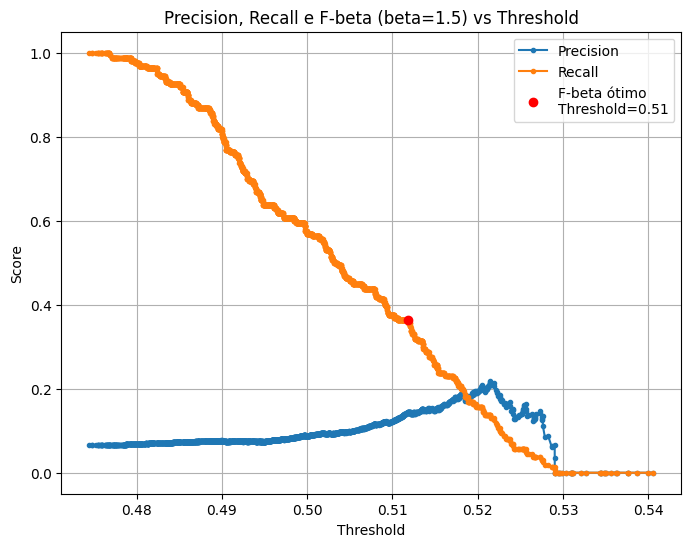

Threshold ótimo: 0.512
Precision: 0.145, Recall: 0.362, F-beta: 0.248
oversampling


39/39 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step


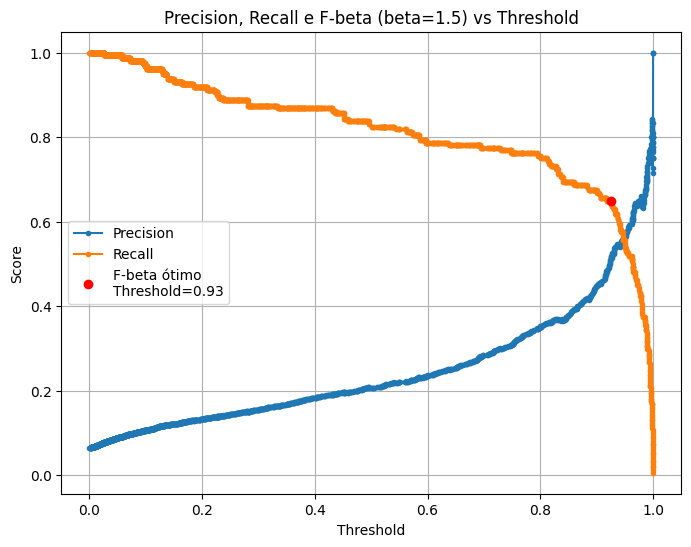

Threshold ótimo: 0.926
Precision: 0.520, Recall: 0.650, F-beta: 0.604
focal_loss


39/39 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step


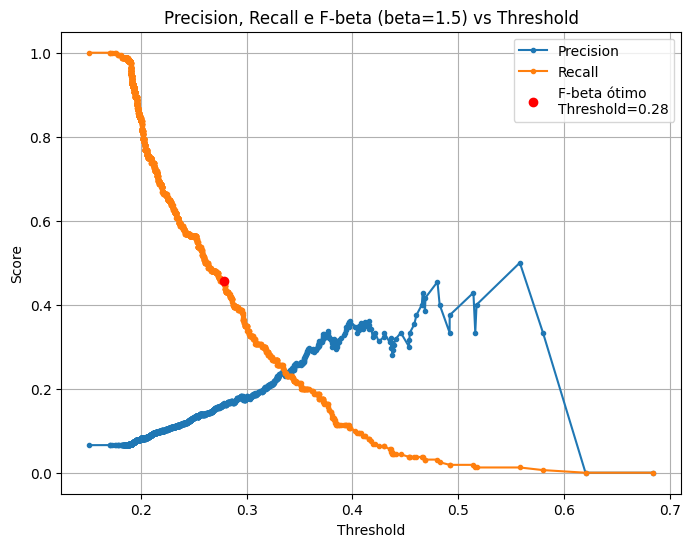

Threshold ótimo: 0.279
Precision: 0.165, Recall: 0.456, F-beta: 0.296
class_weight


39/39 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step


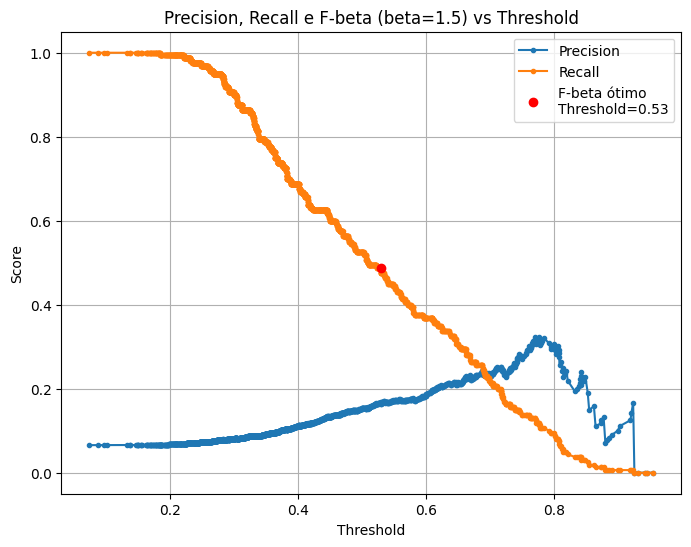

Threshold ótimo: 0.529
Precision: 0.168, Recall: 0.487, F-beta: 0.307
under + cluster


39/39 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step


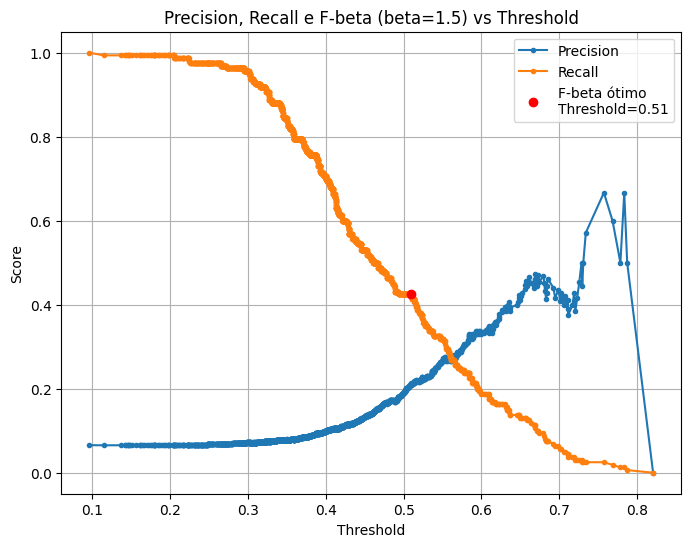

Threshold ótimo: 0.509
Precision: 0.211, Recall: 0.425, F-beta: 0.324
over + cluster


39/39 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step


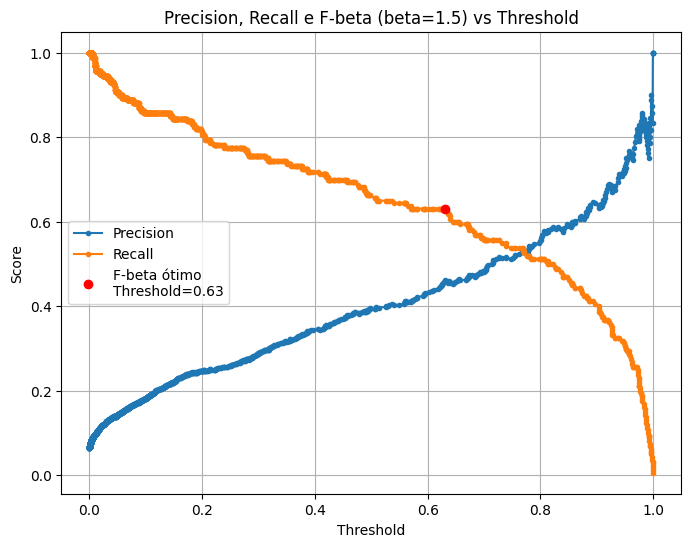

Threshold ótimo: 0.631
Precision: 0.461, Recall: 0.631, F-beta: 0.567


In [ ]:
from tensorflow.keras.models import load_model

image_dir = '/content/drive/MyDrive/IC - Fundo de Olhoo/unzipped/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.1/fundus_photos'

for split_df in [train_df, val_df, test_df]:
    split_df['filepath'] = image_dir + '/' + split_df['image_id'] + '.jpg'

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

val_gen = val_aug.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

val_gen.reset()

test_gen = val_aug.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

print("undersampling")
undersampling = load_model('/content/drive/MyDrive/undersampling.h5')
under_thsould = avaliate_threshold(undersampling, val_gen, val_df)

print("oversampling")
oversampling = load_model('/content/drive/MyDrive/oversampling.h5')
oversampling_thsould = avaliate_threshold(oversampling, val_gen, val_df)

def focal_loss(gamma=2., alpha=0.7):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1-y_pred)
        return -tf.reduce_mean(alpha * tf.pow(1-pt, gamma) * tf.math.log(pt))
    return loss

print("focal_loss")
focal_loss_model = load_model(
    '/content/drive/MyDrive/focal_loss.h5',
    custom_objects={'loss': focal_loss()}
)
focal_thsould = avaliate_threshold(focal_loss_model, val_gen, val_df)

print("class_weight")
class_weight = load_model('/content/drive/MyDrive/peso_classe.h5')
class_weight_thsould = avaliate_threshold(class_weight, val_gen, val_df)

print("under + cluster")
under_cluster = load_model('/content/drive/MyDrive/undersampling_cluster.h5')
undercluster_thsould = avaliate_threshold(under_cluster, val_gen, val_df)

print("over + cluster")
over_cluster = load_model('/content/drive/MyDrive/oversampling_clusterr.h5')
overcluster_thsould = avaliate_threshold(over_cluster, val_gen, val_df)

In [ ]:
def avaliar_modelo_final(model, test_gen, test_df, threshold=0.5):
    y_pred_prob = model.predict(test_gen).flatten()

    y_pred = (y_pred_prob > threshold).astype(int)
    y_true = test_df['diabetic_retinopathy'].values

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_pred_prob)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    especificidade = tn / (tn + fp)

    print(f"Accuracy:       {acc:.4f}")
    print(f"Precision:      {prec:.4f}")
    print(f"Recall:         {rec:.4f}")
    print(f"Specificity:    {especificidade:.4f}")
    print(f"F1-score:       {f1:.4f}")
    print(f"AUC-ROC:        {auc:.4f}")

In [ ]:
from tensorflow.keras.models import load_model

image_dir = '/content/drive/MyDrive/IC - Fundo de Olhoo/unzipped/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.1/fundus_photos'

for split_df in [train_df, val_df, test_df]:
    split_df['filepath'] = image_dir + '/' + split_df['image_id'] + '.jpg'

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64
)

val_gen = val_aug.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

val_gen.reset()

test_gen = val_aug.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='diabetic_retinopathy',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

print("undersampling")
undersampling = load_model('/content/drive/MyDrive/undersampling.h5')
avaliar_modelo_final(undersampling, test_gen, test_df)

print("oversampling")
oversampling = load_model('/content/drive/MyDrive/oversampling.h5')
avaliar_modelo_final(oversampling, test_gen, test_df)

print("class_weight")
class_weight = load_model('/content/drive/MyDrive/peso_classe.h5')
avaliar_modelo_final(class_weight, test_gen, test_df)

print("under + cluster")
under_cluster = load_model('/content/drive/MyDrive/undersampling_cluster.h5')
avaliar_modelo_final(under_cluster, test_gen, test_df)

print("over + cluster")
over_cluster = load_model('/content/drive/MyDrive/oversampling_clusterr.h5')
avaliar_modelo_final(over_cluster, test_gen, test_df)

print("=====THSOULD=====")

print("undersampling")
undersampling = load_model('/content/drive/MyDrive/undersampling.h5')
avaliar_modelo_final(undersampling, test_gen, test_df, 0.512)

print("oversampling")
oversampling = load_model('/content/drive/MyDrive/oversampling.h5')
avaliar_modelo_final(oversampling, test_gen, test_df,  0.926)

print("class_weight")
class_weight = load_model('/content/drive/MyDrive/peso_classe.h5')
avaliar_modelo_final(class_weight, test_gen, test_df, 0.529)

print("under + cluster")
under_cluster = load_model('/content/drive/MyDrive/undersampling_cluster.h5')
avaliar_modelo_final(under_cluster, test_gen, test_df, 0.509)

print("over + cluster")
over_cluster = load_model('/content/drive/MyDrive/oversampling_clusterr.h5')
avaliar_modelo_final(over_cluster, test_gen, test_df, 0.631)

Found 8949 validated image filenames.
Found 2437 validated image filenames.
Found 4880 validated image filenames.
undersampling


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


77/77 ━━━━━━━━━━━━━━━━━━━━ 4075s 54s/step
Accuracy:       0.5830
Precision:      0.0965
Recall:         0.6386
Specificity:    0.5791
F1-score:       0.1677
AUC-ROC:        0.6614
oversampling


77/77 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step
Accuracy:       0.7793
Precision:      0.2106
Recall:         0.8567
Specificity:    0.7739
F1-score:       0.3380
AUC-ROC:        0.8974
class_weight


77/77 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step
Accuracy:       0.7789
Precision:      0.1604
Recall:         0.5576
Specificity:    0.7945
F1-score:       0.2491
AUC-ROC:        0.7275
under + cluster


77/77 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step
Accuracy:       0.8340
Precision:      0.1861
Recall:         0.4517
Specificity:    0.8609
F1-score:       0.2636
AUC-ROC:        0.6999
over + cluster


77/77 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step
Accuracy:       0.9131
Precision:      0.4101
Recall:         0.7321
Specificity:    0.9259
F1-score:       0.5257
AUC-ROC:        0.9008
=====THSOULD=====
undersampling


77/77 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step
Accuracy:       0.8176
Precision:      0.1412
Recall:         0.3489
Specificity:    0.8506
F1-score:       0.2011
AUC-ROC:        0.6614
oversampling


77/77 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step
Accuracy:       0.9412
Precision:      0.5464
Recall:         0.6231
Specificity:    0.9636
F1-score:       0.5822
AUC-ROC:        0.8974
class_weight


77/77 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step
Accuracy:       0.8002
Precision:      0.1656
Recall:         0.5047
Specificity:    0.8210
F1-score:       0.2494
AUC-ROC:        0.7275
under + cluster


77/77 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step
Accuracy:       0.8471
Precision:      0.1960
Recall:         0.4268
Specificity:    0.8767
F1-score:       0.2686
AUC-ROC:        0.6999
over + cluster


77/77 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step
Accuracy:       0.9273
Precision:      0.4637
Recall:         0.6760
Specificity:    0.9449
F1-score:       0.5501
AUC-ROC:        0.9008
